# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [55]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    get_ipython().run_line_magic('load_ext', 'autoreload')

get_ipython().run_line_magic('autoreload', '2')


# scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# models
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.classifier import LogisticRegression as extLogisticRegression
# xgboost
from xgboost import XGBClassifier

# processing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import ColumnSelector
from sklearn import model_selection

# feature selection
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold, chi2

# feature agglomeration
from sklearn.cluster import FeatureAgglomeration

# benchmark
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, multilabel_confusion_matrix, auc, matthews_corrcoef, roc_auc_score, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pickle

# Visualizations
import matplotlib.pyplot as plt
# Set default font size
plt.rcParams['font.size'] = 24
import seaborn as sb
# Set default font size
sb.set(font_scale = .8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)

# Interactive Visualizations
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# icf.set_config_file(theme='white')

# Analysis/Modeling
Do work here

In [56]:
# target catagorical variable is a binary split of 
# Cetuximab IC50 on CRC lines values by their median
target_col =  "IC50_byMedian_cat"


# encoded expr data w/t progeny pathway scores + msdb hallmarks ssGSEA scores
# colinearity filter + chi2
f = 'tables/CMP+GDSC_preprocessed_features/exprPath_PROGENy+HALLMARK.tsv'
Expr = pd.read_csv(f, sep="\t", header=0, index_col=0)
Expr = Expr[Expr.columns.drop(list(Expr.filter(regex='Cetuximab')))]
Expr.columns = [c + "_expr" for c in Expr.columns]

# feature agglomeration CNV, input includes highGain features
f = "tables/CMP+GDSC_preprocessed_features/highCN.tsv"
CNV = pd.read_csv(f, sep="\t", header=0, index_col=0)
CNV = CNV[CNV.columns.drop(list(CNV.filter(regex='Cetuximab')))]
CNV.columns = [c + "_cnv" for c in CNV.columns]

# custom mut feature cross w/t top 20 features by chi2
f = "tables/CMP+GDSC_preprocessed_features/mut_ComboMulti.tsv"
Mut = pd.read_csv(f, sep="\t", header=0, index_col=0)
Mut = Mut[Mut.columns.drop(list(Mut.filter(regex='Cetuximab')))]
Mut.columns = [c + "_mut" for c in Mut.columns]

# load drug response data (GDSC Cetuximab CRC lines screen)
f =  'tables/DrugResponse_CMP+GDSC_CRCcetuximab_trainTest.csv'
Y = pd.read_csv(f, 
sep="\t", index_col=None).set_index('SANGER_MODEL_ID')

# feature blocks are in thisx order: mut, cnv, expr
df1 = pd.merge(Mut, CNV, right_index=True, left_index=True, how="outer")
all_df = pd.merge(df1, Expr, right_index=True, left_index=True, how="outer")
feature_col = all_df.columns.tolist()
all_df =  all_df.select_dtypes([np.number])
all_df = pd.merge(all_df, Y[target_col], right_index=True, left_index=True, how="right")

# drop duplicated instances (SANGER_MODEL_ID) from index
all_df = all_df[~all_df.index.duplicated(keep='first')]
# fillna in features with median imputation
all_df[feature_col] = all_df[feature_col].\
        astype(float).apply(lambda col:col.fillna(col.median()))


# train-test split
train_models = Y[Y.is_test == False].index.unique()
test_models = Y[Y.is_test == True].index.unique()
X_train = all_df.loc[train_models, feature_col]
y_train  = all_df.loc[train_models, target_col]
X_test = all_df.loc[test_models, feature_col]
y_test = all_df.loc[test_models, target_col]

#scale features sapartaely
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train.values),
          columns=X_train.columns, index=X_train.index)

scaler = MinMaxScaler().fit(X_test)              
X_test = pd.DataFrame(scaler.transform(X_test.values),
          columns=X_test.columns, index=X_test.index)    
X_train.shape
X_test.shape



# get indeces for feature subsets, one per OMIC
Mut_indeces = list(range(0, Mut.shape[1]))
pos = len(Mut_indeces)
CNV_indeces = list(range(Mut_indeces[-1]+1, pos + CNV.shape[1]))
pos += len(CNV_indeces)
Expr_indeces = list(range(CNV_indeces[-1]+1, pos + Expr.shape[1]))

(31, 652)

(13, 652)

In [57]:
all_df.iloc[:,Mut_indeces[-1]+1]

SANGER_MODEL_ID
SIDM00783    0.0
SIDM00136    1.0
SIDM00826    0.0
SIDM00841    1.0
SIDM00118    1.0
            ... 
SIDM00214    0.0
SIDM00194    0.0
SIDM00193    0.0
SIDM00498    0.0
SIDM00049    0.0
Name: ABCB1_Gain_cnv, Length: 44, dtype: float64

In [58]:
# pipeline to train a classifier on expression data alone
pipe_steps = [
    ("ColumnSelector", ColumnSelector(cols=Expr_indeces)),
    ("chi2filterFscore", SelectKBest(chi2)), 
    ('RFClassifier', RandomForestClassifier(criterion='gini', class_weight='balanced')),
]
pipeExpr = Pipeline(pipe_steps)

# pipeline to train a classifier on mutation data alone
pipe_steps = [
    ("ColumnSelector", ColumnSelector(cols=Mut_indeces)),
    ("chi2filterFscore", SelectKBest(chi2)), # univariate filter on chi2 stat
    ('RFClassifier', RandomForestClassifier(criterion='gini', class_weight='balanced')),
]
pipeMut = Pipeline(pipe_steps)

# pipeline to train a classifier on CNV data alone
pipe_steps = [
    ("ColumnSelector", ColumnSelector(cols=CNV_indeces)),
     # remove samples which have the same val in 85% or more samples
    ("VarianceFilter", VarianceThreshold(threshold=(.75 * (1 - .75)))),
    ("WardAgg", FeatureAgglomeration()), # Ward feature agglomeration by mean
    ("chi2filterFscore", SelectKBest(chi2)), 
    ('RFClassifier', RandomForestClassifier(criterion='gini', class_weight='balanced')),
]
pipeCNV = Pipeline(pipe_steps)

# build the meta classifier
sclf = StackingCVClassifier(classifiers=[pipeExpr, pipeMut, pipeCNV], 
                          cv=3, random_state=13, verbose=1,
                          #use_probas=True, #average_probas=False,
                          #use_features_in_secondary=True,
                          meta_classifier=LogisticRegression(penalty='l2', class_weight='balanced'))

hyperparameter_grid = {
          # Expr params 
          'pipeline-1__chi2filterFscore__k': [25],
          'pipeline-1__RFClassifier__max_features' : [.2],
          'pipeline-1__RFClassifier__min_samples_split' : [.4],
          'pipeline-1__RFClassifier__n_estimators' : [15],
          'pipeline-1__RFClassifier__max_depth' : [11],
          #'pipeline-2__': [],
          # Mut params
          'pipeline-2__chi2filterFscore__k': [50],
          'pipeline-2__RFClassifier__max_features' : [.2],
          'pipeline-2__RFClassifier__min_samples_split' : [.01],
          'pipeline-2__RFClassifier__n_estimators' : [15],
          'pipeline-2__RFClassifier__max_depth' : [11],
          #'pipeline-3__' : [],
          # CNV params
          'pipeline-3__WardAgg__n_clusters' : [40],
          'pipeline-3__chi2filterFscore__k': [12],
          'pipeline-3__RFClassifier__max_features' : [.4],
          'pipeline-3__RFClassifier__min_samples_split' : [.4],
          'pipeline-3__RFClassifier__n_estimators' : [10],
          'pipeline-3__RFClassifier__max_depth' : [3],
          # meta classifier params
          'meta_classifier__C':  np.linspace(.01, .9, 10, endpoint=True)
          }

# Set up the random search with 4-fold stratified cross validation
skf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)
grid = GridSearchCV(estimator=sclf, 
                    param_grid=hyperparameter_grid, 
                    n_jobs=-1,
                    cv=skf,
                    refit=True,
                    verbose=2)
grid.fit(X_train, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))


Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 3 classifiers...
Fitting classifier1: pipeline (1/3)
Fitting classifier2: pipeline (2/3)
Fitting classifier3: pipeline (3/3)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=StackingCVClassifier(classifiers=[Pipeline(steps=[('ColumnSelector',
                                                                          ColumnSelector(cols=[619,
                                                                                               620,
                                                                                               621,
                                                                                               622,
                                                                                               623,
                                                                                               624,
                                                                                               625,
                                                                                               626,
                                

0.674 +/- 0.04 {'meta_classifier__C': 0.01, 'pipeline-1__RFClassifier__max_depth': 11, 'pipeline-1__RFClassifier__max_features': 0.2, 'pipeline-1__RFClassifier__min_samples_split': 0.4, 'pipeline-1__RFClassifier__n_estimators': 15, 'pipeline-1__chi2filterFscore__k': 25, 'pipeline-2__RFClassifier__max_depth': 11, 'pipeline-2__RFClassifier__max_features': 0.2, 'pipeline-2__RFClassifier__min_samples_split': 0.01, 'pipeline-2__RFClassifier__n_estimators': 15, 'pipeline-2__chi2filterFscore__k': 50, 'pipeline-3__RFClassifier__max_depth': 3, 'pipeline-3__RFClassifier__max_features': 0.4, 'pipeline-3__RFClassifier__min_samples_split': 0.4, 'pipeline-3__RFClassifier__n_estimators': 10, 'pipeline-3__WardAgg__n_clusters': 40, 'pipeline-3__chi2filterFscore__k': 12}
0.705 +/- 0.06 {'meta_classifier__C': 0.10888888888888888, 'pipeline-1__RFClassifier__max_depth': 11, 'pipeline-1__RFClassifier__max_features': 0.2, 'pipeline-1__RFClassifier__min_samples_split': 0.4, 'pipeline-1__RFClassifier__n_estima

# Results
Show graphs and stats here

In [59]:

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'meta_classifier__C': 0.7022222222222222, 'pipeline-1__RFClassifier__max_depth': 11, 'pipeline-1__RFClassifier__max_features': 0.2, 'pipeline-1__RFClassifier__min_samples_split': 0.4, 'pipeline-1__RFClassifier__n_estimators': 15, 'pipeline-1__chi2filterFscore__k': 25, 'pipeline-2__RFClassifier__max_depth': 11, 'pipeline-2__RFClassifier__max_features': 0.2, 'pipeline-2__RFClassifier__min_samples_split': 0.01, 'pipeline-2__RFClassifier__n_estimators': 15, 'pipeline-2__chi2filterFscore__k': 50, 'pipeline-3__RFClassifier__max_depth': 3, 'pipeline-3__RFClassifier__max_features': 0.4, 'pipeline-3__RFClassifier__min_samples_split': 0.4, 'pipeline-3__RFClassifier__n_estimators': 10, 'pipeline-3__WardAgg__n_clusters': 40, 'pipeline-3__chi2filterFscore__k': 12}
Accuracy: 0.83


In [60]:
# pickle best model from gridCV
model_filename = "models/CMP+GDSC_stacked_Omics_binary_MultiCVclassifier_exprPROGENyHALLMARKS+highCNagg.pkl" 

with open(model_filename,'wb') as f:
    pickle.dump(grid.best_estimator_,f)


Accuracy on test set: 0.692
              precision    recall  f1-score   support

          PD       0.75      0.50      0.60         6
       SD-OR       0.67      0.86      0.75         7

    accuracy                           0.69        13
   macro avg       0.71      0.68      0.68        13
weighted avg       0.71      0.69      0.68        13



0.6547619047619048

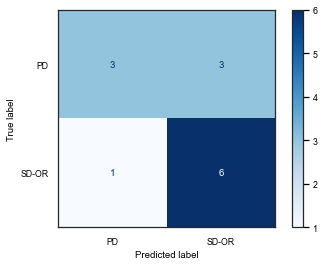

In [61]:


# In[70]:


# load the model from file
classifier = pickle.load(open(model_filename, 'rb'))
# assess best classifier performance on test set
grid_test_score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)
print(f'Accuracy on test set: {grid_test_score:.3f}')
# print classification report on test set
print(classification_report(y_test, y_pred, target_names=['PD', 'SD-OR']))


# In[71]:


#confusion_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=['PD', 'SD-OR'],
                                 cmap=plt.cm.Blues)


# In[72]:


# Learn to predict e/a class against e/a other
#OVRclassifier = OneVsRestClassifier(classifier)
# returns the marginal probability that the given sample has the label in question
y_test_predict_proba = classifier.predict_proba(X_test)
roc_auc_score(y_test, y_test_predict_proba[:, 1])

# Conclusions and Next Steps
Summarize findings here